<a id="top">#top</a>
# Predicting Red Light Violations at Chicago Intersections
<p>This project will attempt to predict red light violations at Chicago intersections with the goal of creating a sliding scale of fines based on intersections with the highest risk of violations under given conditions such as season, day of the week and weather conditions. 

Two datasets were used in this analysis, [Chicago Red Light and Speed Camera Data](https://www.kaggle.com/chicago/chicago-red-light-and-speed-camera-data) and weather data from the Chicago O'Hare airport [NOAA GSO](https://www.kaggle.com/noaa/gsod). Both of these data sets are available on Kaggle and as files in this project.</p>

## Table of Contents
- [1. Preprocessing](#1)
    - [1.1 Load violations and temperature data](#1.1)
    - [1.2 Clean data and feature engineering](#1.2)
- [2. Exploratory Analysis](#2)
    - [2.1 Time series trends](#2.1)
    - [2.2 Correlation between features and violations](#2.2)
    - [2.3 Kmeans clustering with categorical features](#2.3)
- [3. Prediction](#3)
    - [3.1 Linear Regression](#3.1)
    - [3.2 ARIMA](#3.2)
    - [3.3 FAcebook Prophet](#3.3)
- [4. Conclusions](#4)

In [1]:


# Update necessary packages first
!pip3 uninstall --yes fbprophet
!pip3 install fbprophet --no-cache-dir --no-binary :all:
!pip3 install pydotplus --no-cache-dir --no-binary :all:

Found existing installation: fbprophet 0.6
Uninstalling fbprophet-0.6:
  Successfully uninstalled fbprophet-0.6
     |████████████████████████████████| 54 kB 2.2 MB/s eta 0:00:011
Skipping wheel build for fbprophet, due to binaries being disabled for it.
    Running setup.py install for fbprophet ... done
     |████████████████████████████████| 278 kB 2.7 MB/s eta 0:00:01
Skipping wheel build for pydotplus, due to binaries being disabled for it.
    Running setup.py install for pydotplus ... done


In [63]:
#import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.spatial import distance
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
import bq_helper
import warnings
from fbprophet.plot import add_changepoints_to_plot
from sklearn.linear_model import LinearRegression
from numpy import mean,absolute
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import t
from fbprophet import Prophet
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

warnings.filterwarnings("ignore")

## Export weather data from noaa


In [3]:
#get weather data for O'Hare airport in Chicago
noaa_data_set = bq_helper.BigQueryHelper(active_project= "bigquery-public-data",
                                        dataset_name= "noaa_gsod")

base_query = """
SELECT
    CAST(CONCAT(year,'-',mo,'-',da) AS date) AS date,
    temp,
    wdsp,
    max AS max_temp,
    min AS min_temp,
    prcp,
    sndp AS snow_depth,
    fog,
    rain_drizzle,
    snow_ice_pellets,
    hail,
    thunder,
    tornado_funnel_cloud
FROM
"""

where_clause = """
WHERE stn='725300'
"""
tables=[
    "`bigquery-public-data.noaa_gsod.gsod2019`",
    "`bigquery-public-data.noaa_gsod.gsod2018`",
    "`bigquery-public-data.noaa_gsod.gsod2017`",
    "`bigquery-public-data.noaa_gsod.gsod2016`",
    "`bigquery-public-data.noaa_gsod.gsod2015`",
    "`bigquery-public-data.noaa_gsod.gsod2014`"]

for t in range(len(tables)):
    if t==0:
        query = "{0} {1} {2} \n".format(base_query,tables[t],where_clause)
    else:
        query+="UNION ALL \n {0} {1} {2}".format(base_query,tables[t],where_clause)

weather_data= noaa_data_set.query_to_pandas_safe(query, max_gb_scanned=2.0)
weather_data['date']=pd.to_datetime(weather_data['date'])

Using Kaggle's public dataset BigQuery integration.


In [4]:
dfWeather = weather_data.copy()
dfViolations = pd.read_csv('../input/chicago-red-light-and-speed-camera-data/red-light-camera-violations.csv')

In [5]:
#Create Ohio University color dictionary
ouColors = {'Cutler Green': '#00694E',
            'Cupola White': '#ffffff',
            'Putnam': '#756e65',
            'Under the Elms': '#024230',
            'Gateway': '#514c47',
            'Wheat': '#fccd06',
            'PawPaw': '#e0dc4b'}

## <a id="1.2">1.2 Clean data and feature engineering</a> 
[top](#top)

In [6]:
#remove null values from the violations data set
originalViolations = len(dfViolations)
dfViolations = dfViolations.dropna()
remaining = len(dfViolations)
recordsWithMissingVal = originalViolations - remaining

removeNaText = f'{recordsWithMissingVal:,} of the original {originalViolations:,} records were removed because at least one value was missing. \
                \n{remaining:,} records remaining.'

print(removeNaText)

27,583 of the original 521,533 records were removed because at least one value was missing.                 
493,950 records remaining.


In [7]:
#remove duplicated rows from the dataframe
dfViolations[dfViolations.duplicated()]

,INTERSECTION,CAMERA ID,ADDRESS,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
50001,CALIFORNIA AND DIVERSEY,1513.0,2800 W DIVERSEY,2019-05-18T00:00:00.000,2,1.157213e+06,1.918527e+06,41.932205,-87.697679,"{'latitude': '41.93220539506452', 'human_addre...",15.0,22535.0,22.0,466.0,20.0
70000,CENTRAL AND BELMONT,1604.0,5600 W BELMONT AVENUE,2019-03-01T00:00:00.000,1,1.138454e+06,1.920756e+06,41.938684,-87.766562,"{'latitude': '41.93868377475747', 'human_addre...",25.0,22254.0,15.0,342.0,21.0
80000,STONEY ISLAND AND 76TH,2632.0,7600 S STONY ISLAND A,2019-01-19T00:00:00.000,6,1.188093e+06,1.854889e+06,41.756897,-87.586234,"{'latitude': '41.75689717260223', 'human_addre...",32.0,22538.0,39.0,188.0,33.0
150000,ASHLAND AND MADISON,1914.0,1600 W MADISON,2018-04-26T00:00:00.000,2,1.165723e+06,1.900137e+06,41.881564,-87.666929,"{'latitude': '41.8815641670199', 'human_addres...",41.0,21184.0,29.0,90.0,46.0
260000,KEDZIE AND 71ST,2352.0,7100 S KEDZIE AVENUE,2017-02-24T00:00:00.000,6,1.156226e+06,1.857330e+06,41.764295,-87.702957,"{'latitude': '41.764295036756856', 'human_addr...",6.0,21867.0,64.0,349.0,31.0
300000,LAKE SHORE DR AND BELMONT,1412.0,3200 N LAKESHORE DRIV,2016-09-29T00:00:00.000,10,1.173053e+06,1.921821e+06,41.940909,-87.639369,"{'latitude': '41.94090916326764', 'human_addre...",38.0,4449.0,57.0,535.0,25.0


In [8]:
#remove the 6 duplicated rows from the dataframe
dfViolations = dfViolations.drop(dfViolations[dfViolations.duplicated()].index)
#make sure that all duplicated rows are gone
dfViolations[dfViolations.duplicated()]

,INTERSECTION,CAMERA ID,ADDRESS,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards


In [9]:
#remove neighborhood identifier columns because they are not unique for each intersection
cols = ['INTERSECTION', 'VIOLATION DATE', 'VIOLATIONS']
dfViolations = dfViolations.groupby(['INTERSECTION','VIOLATION DATE']).sum()
dfViolations = dfViolations.reset_index()
dfViolations = dfViolations[cols]

In [10]:
dfViolations.head()

,INTERSECTION,VIOLATION DATE,VIOLATIONS
0,111TH AND HALSTED,2014-07-23T00:00:00.000,6
1,111TH AND HALSTED,2014-07-24T00:00:00.000,12
2,111TH AND HALSTED,2014-07-25T00:00:00.000,11
3,111TH AND HALSTED,2014-07-26T00:00:00.000,13
4,111TH AND HALSTED,2014-07-27T00:00:00.000,5


In [11]:
#Convert violation date to datetime format and add year, month and day of week columns
dfViolations['VIOLATION DATE'] = pd.to_datetime(dfViolations['VIOLATION DATE'])
dfViolations['year'] = dfViolations['VIOLATION DATE'].dt.year
dfViolations['month'] = dfViolations['VIOLATION DATE'].dt.month
#week starts on Monday
dfViolations['dow'] = dfViolations['VIOLATION DATE'].dt.dayofweek
dfViolations.set_index('VIOLATION DATE', inplace=True)

In [12]:
#merge weather into the violations data frame
dfWeather['date'] = pd.to_datetime(dfWeather['date'])
dfWeather = dfWeather.set_index('date')

dfViolationsWithWeather = dfViolations.merge(dfWeather, right_index=True, left_index=True)

In [13]:
#if the snow depth is equal to 999.9 replace it with 0
dfViolationsWithWeather['snow_depth'] = dfViolationsWithWeather['snow_depth'].replace(999.9,0)

#replace min_temp and max_temp = 9999.9 with temp
mask = (dfViolationsWithWeather['min_temp']==9999.9) & (dfViolationsWithWeather['temp']!=9999.9)
dfViolationsWithWeather['min_temp'][mask]=dfViolationsWithWeather['temp']

mask = (dfViolationsWithWeather['max_temp']==9999.9) & (dfViolationsWithWeather['temp']!=9999.9)
dfViolationsWithWeather['max_temp'][mask]=dfViolationsWithWeather['temp']

#no tornado's were reported in during this timeframe by the NOAA dataset so the tornado column is dropped
dfViolationsWithWeather.drop(columns=['tornado_funnel_cloud']
                            , inplace=True)
dfViolationsWithWeather = dfViolationsWithWeather.astype({'fog': 'int',
                               'rain_drizzle': 'int',
                               'snow_ice_pellets': 'int',
                               'hail': 'int',
                               'thunder': 'int',
                                'wdsp': 'float64'})

In [14]:
#create a multi index by Intersection and date
summaryColumns = ['VIOLATION DATE','year', 'month', 'dow', 'temp', 'wdsp', 'max_temp',
       'min_temp', 'prcp', 'snow_depth', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'hail', 'thunder']

dfViolationsWithWeather = dfViolationsWithWeather.reset_index()
dfViolationsWithWeather.rename(columns={"index": "VIOLATION DATE"}, inplace=True)

#Create a consolidated dataframe for high level exploratory analysis
dfGroupedViolations = dfViolationsWithWeather.groupby(summaryColumns)[['VIOLATIONS']].sum()
dfGroupedViolations = dfGroupedViolations.reset_index()
dfGroupedViolations = dfGroupedViolations.set_index(['VIOLATION DATE'])

dfViolationsWithWeather = dfViolationsWithWeather.sort_values(by=['INTERSECTION', 'VIOLATION DATE'])
dfViolationsWithWeather = dfViolationsWithWeather.set_index(['INTERSECTION','VIOLATION DATE'])

In [15]:
#add 7 day and 365 day moving averages to the summarized and full dataframes
dfViolationsWithWeather['7Day'] = dfViolationsWithWeather.groupby(level=0)['VIOLATIONS'].rolling(window=7, center=False).mean().values
dfViolationsWithWeather['365Day'] = dfViolationsWithWeather.groupby(level=0)['VIOLATIONS'].rolling(window=365, center=False).mean().values
dfGroupedViolations['7Day'] = dfGroupedViolations['VIOLATIONS'].rolling(window=7, center=False).mean().values
dfGroupedViolations['365Day'] = dfGroupedViolations['VIOLATIONS'].rolling(window=365, center=False).mean().values

In [16]:
#unique values in the data frame
pd.DataFrame(dfViolationsWithWeather.nunique(), columns=['Count'])

,Count
VIOLATIONS,162
year,6
month,12
dow,7
temp,691
wdsp,165
max_temp,105
min_temp,121
prcp,139
snow_depth,17


In [17]:
#data types in the data frame
pd.DataFrame(dfViolationsWithWeather.dtypes, columns=['DataType'])

,DataType
VIOLATIONS,int64
year,int64
month,int64
dow,int64
temp,float64
wdsp,float64
max_temp,float64
min_temp,float64
prcp,float64
snow_depth,float64


In [18]:
pd.DataFrame(pd.DataFrame(list(dfViolationsWithWeather.index), columns=['Intersection', 'Date'])['Intersection'].value_counts())

,Intersection
ROOSEVELT AND HALSTED,1970
CORTLAND AND ASHLAND,1970
CALIFORNIA AND DIVERSEY,1970
SACRAMENTO AND CHICAGO,1969
STONY ISLAND/CORNELL AND 67TH,1968
...,...
PULASKI AND MONTROSE,201
HARLEM AND NORTHWEST HWY,199
WESTERN AND ARMITAGE,193
JEFFERY AND 79TH,191


## <a id="2">2. Exploratory Analysis</a>  

### <a id="2.1">2.1 Time Series Trends</a>

[top](#top)

In [19]:
#how many unique intersections are in the dataset?
numIntersections = len(set(dfViolationsWithWeather.index.get_level_values(0)))
numRecords = len(dfViolationsWithWeather)
startDate = dfViolationsWithWeather.index.get_level_values(1).min().strftime('%m/%d/%Y')
endDate = dfViolationsWithWeather.index.get_level_values(1).max().strftime('%m/%d/%Y')

summary = f'The cleaned dataset includes {numRecords:,} records for {numIntersections}'
summary += f' unique intersections collected between {startDate} and {endDate}'

print(summary)

The cleaned dataset includes 282,897 records for 179 unique intersections collected between 07/01/2014 and 11/21/2019


In [20]:
#which cameras/locations had the most violations?
top5Intersections = dfViolationsWithWeather.groupby(level=0)['VIOLATIONS'].sum().sort_values(ascending=False).head(5).index
pd.DataFrame(list(top5Intersections),columns=['Intersection'])

,Intersection
0,CICERO AND I55
1,LAKE SHORE DR AND BELMONT
2,LAFAYETTE AND 87TH
3,STATE AND 79TH
4,VAN BUREN AND WESTERN


In [21]:
#Intersection share of total violations
dfIntersections =(dfViolationsWithWeather.groupby(level=0)['VIOLATIONS'].sum().sort_values(ascending=False)/
                dfViolationsWithWeather['VIOLATIONS'].sum())*100

#Violations are spread out between the intersections in Chicago, there isn't a small group that represents most of the violations
dfIntersections.cumsum()[:90].reset_index()

,INTERSECTION,VIOLATIONS
0,CICERO AND I55,4.100724
1,LAKE SHORE DR AND BELMONT,8.032298
2,LAFAYETTE AND 87TH,10.709453
3,STATE AND 79TH,13.024220
4,VAN BUREN AND WESTERN,15.250744
...,...,...
85,DAMEN AND 63RD,79.360180
86,35TH AND WESTERN,79.792755
87,HOMAN/KIMBALL AND NORTH,80.217773
88,STONEY ISLAND AND 79TH,80.634000


### <a id="2.2">2.2 Correlations</a>  
[top](#top)

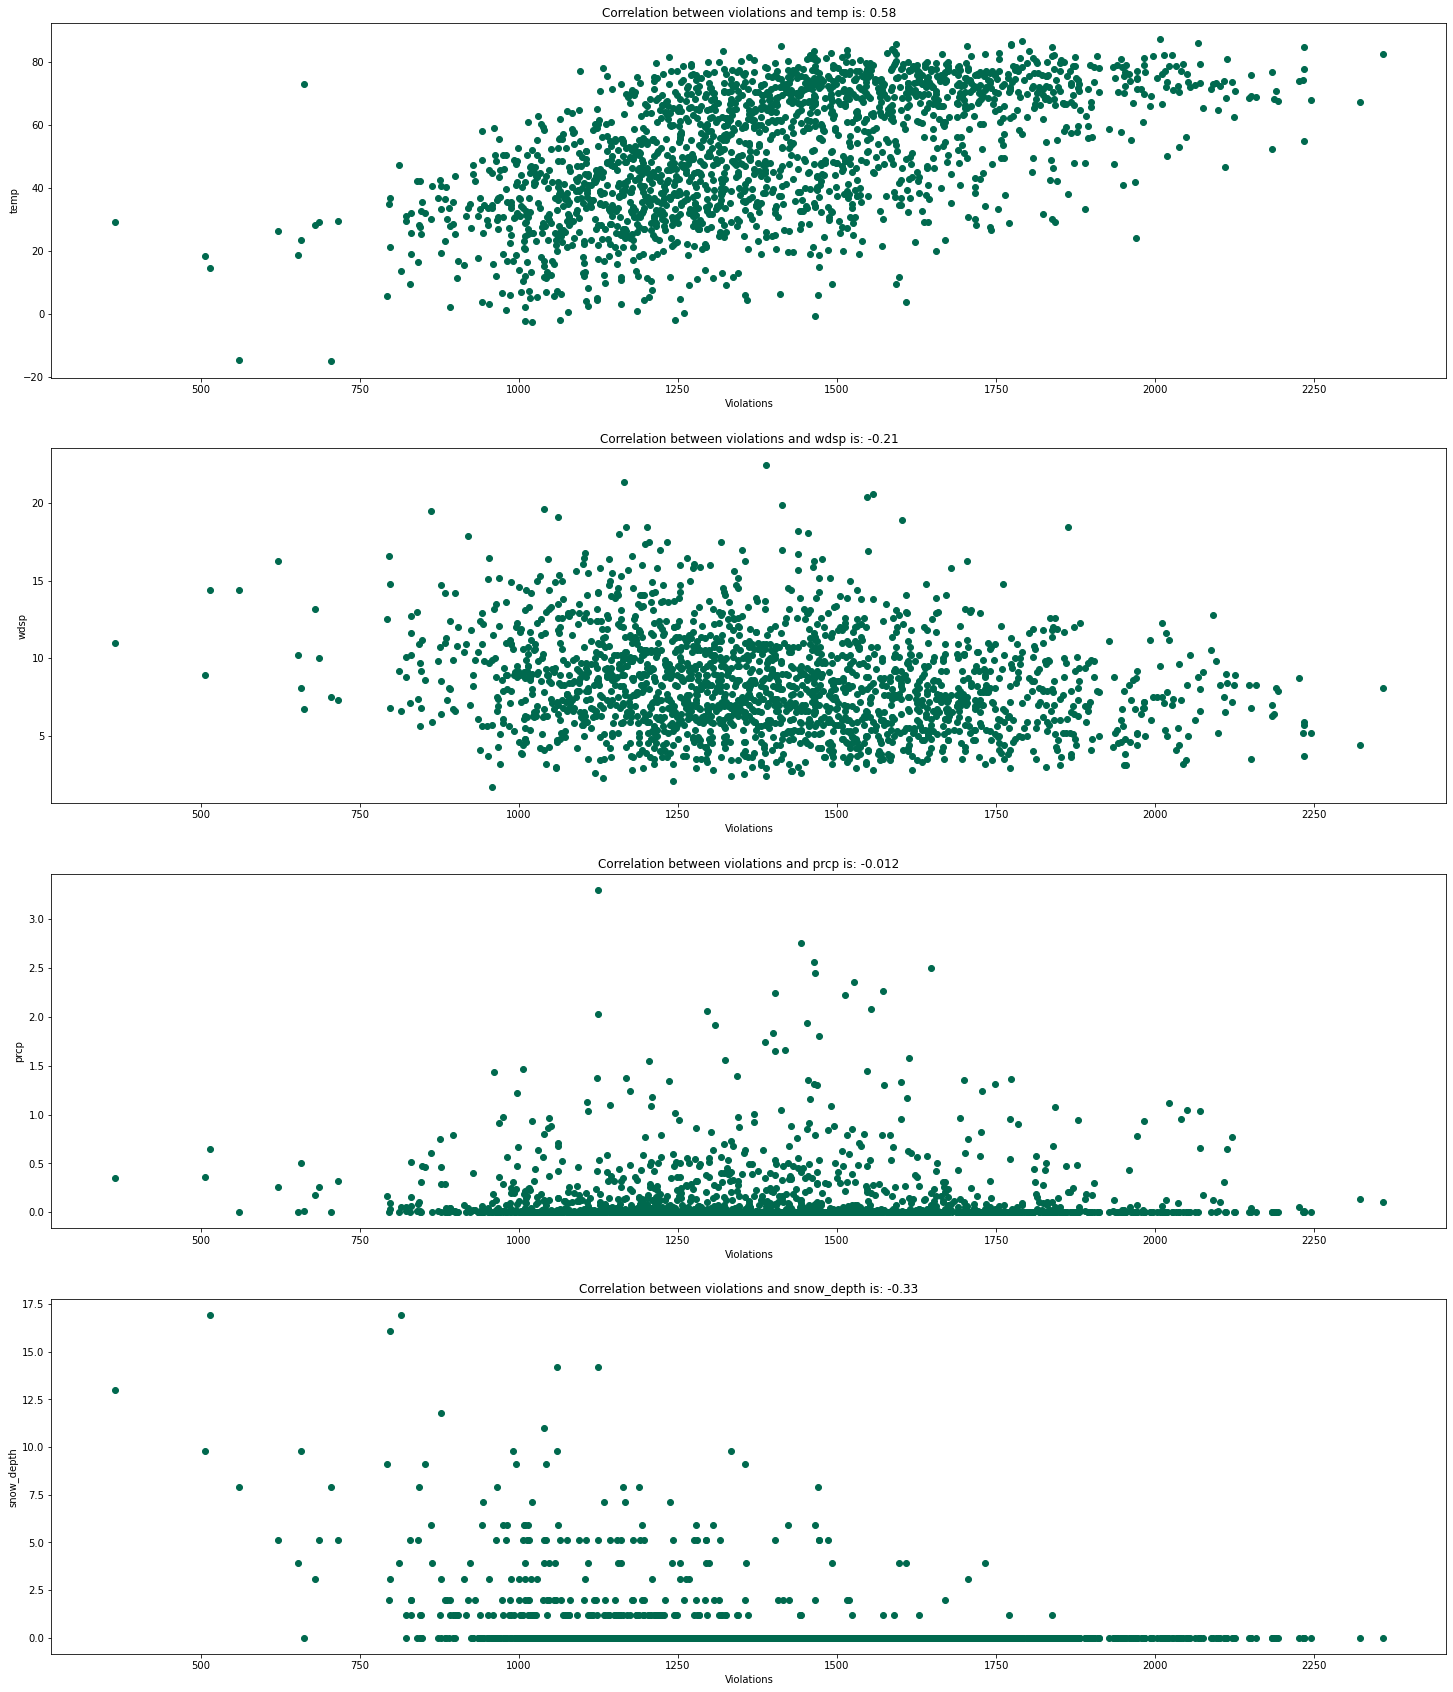

<Figure size 432x288 with 0 Axes>

In [22]:
corrCols = ['temp', 'wdsp', 'prcp', 'snow_depth']

fig, axs = plt.subplots(4, figsize=(25,30))
for f, feature in enumerate(corrCols):
    corr = dfGroupedViolations['VIOLATIONS'].corr(dfGroupedViolations[feature])

    axs[f].plot(dfGroupedViolations['VIOLATIONS'],dfGroupedViolations[feature],'o', color=ouColors['Cutler Green'])
    axs[f].set_xlabel('Violations')
    axs[f].set_ylabel(feature)
    axs[f].set_title(f'Correlation between violations and {feature} is: {corr:.2}')

plt.show()
plt.savefig('correlation.png')

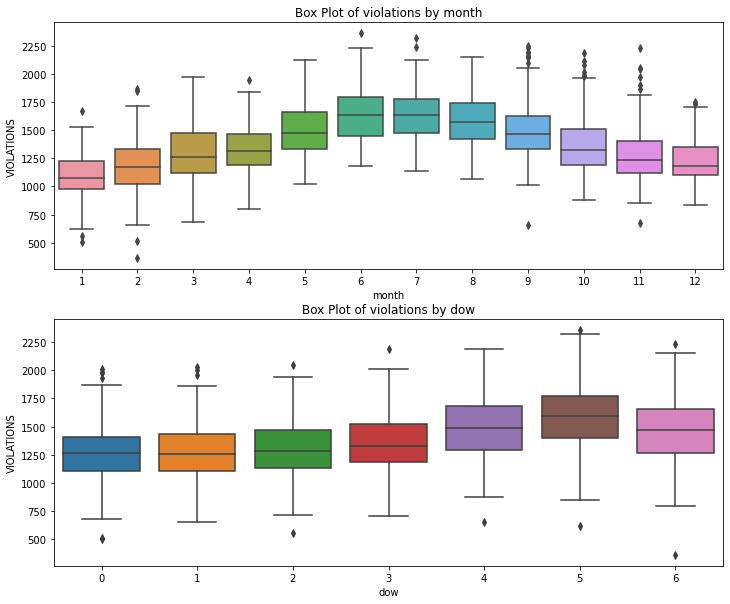

In [23]:
boxplotCols = ['month','dow']

fig, ax = plt.subplots(2, figsize=(12,10))

for f,feature in enumerate(boxplotCols):
    sns.boxplot(x=feature, y='VIOLATIONS', data = dfGroupedViolations, ax=ax[f])
    ax[f].set_title(f'Box Plot of violations by {feature}')
plt.show()

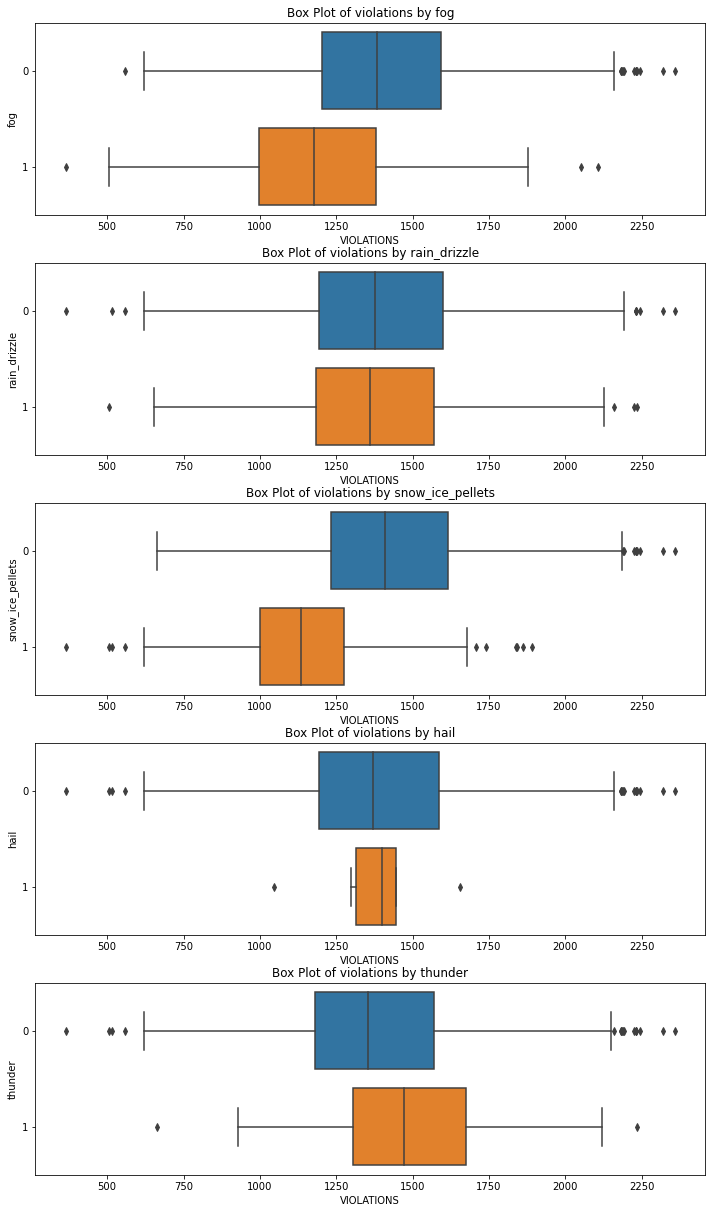

In [24]:
boxplotCols = ['fog','rain_drizzle','snow_ice_pellets','hail','thunder']
fig, ax = plt.subplots(5, figsize=(12,20))

for f,feature in enumerate(boxplotCols):
    sns.boxplot(y=feature, x='VIOLATIONS', data = dfGroupedViolations, orient='h', ax=ax[f])
    ax[f].set_title(f'Box Plot of violations by {feature}')
plt.subplots_adjust(bottom=0.08, hspace=0.25)
plt.show()

## Time Series Trends

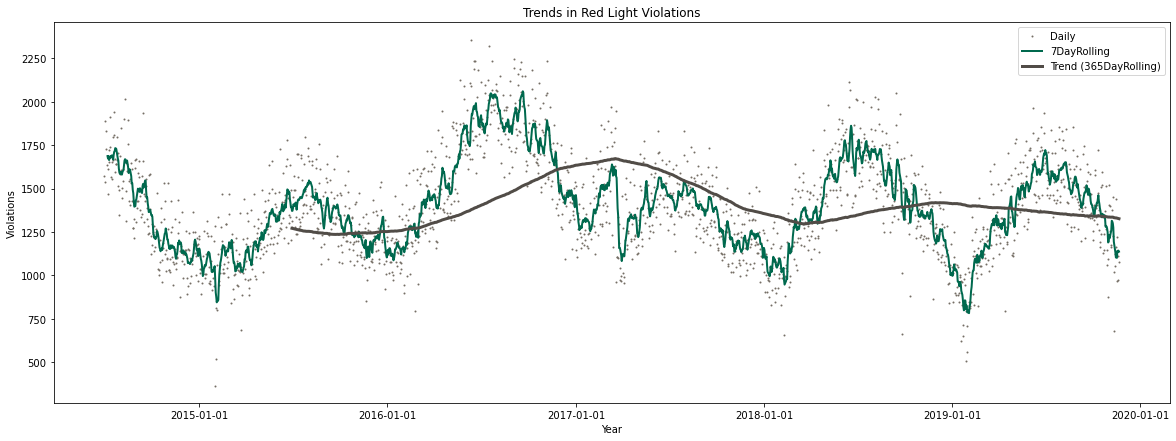

In [25]:
#Plot the summary of 7 day rolling average and 365 day rolling average against the daily violations
fig, ax = plt.subplots(figsize = (20,7))# plotting daily data
ax.plot(dfGroupedViolations['VIOLATIONS'], marker='.', markersize=2, color=ouColors['Putnam'],linestyle='None', label='Daily')
ax.plot(dfGroupedViolations['7Day'], color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')
ax.plot(dfGroupedViolations['365Day'], color=ouColors['Gateway'], linewidth=3, label='Trend (365DayRolling)')


ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Violations')
ax.set_title('Trends in Red Light Violations')

plt.show()

## Time Series trends for the top 5 intersections

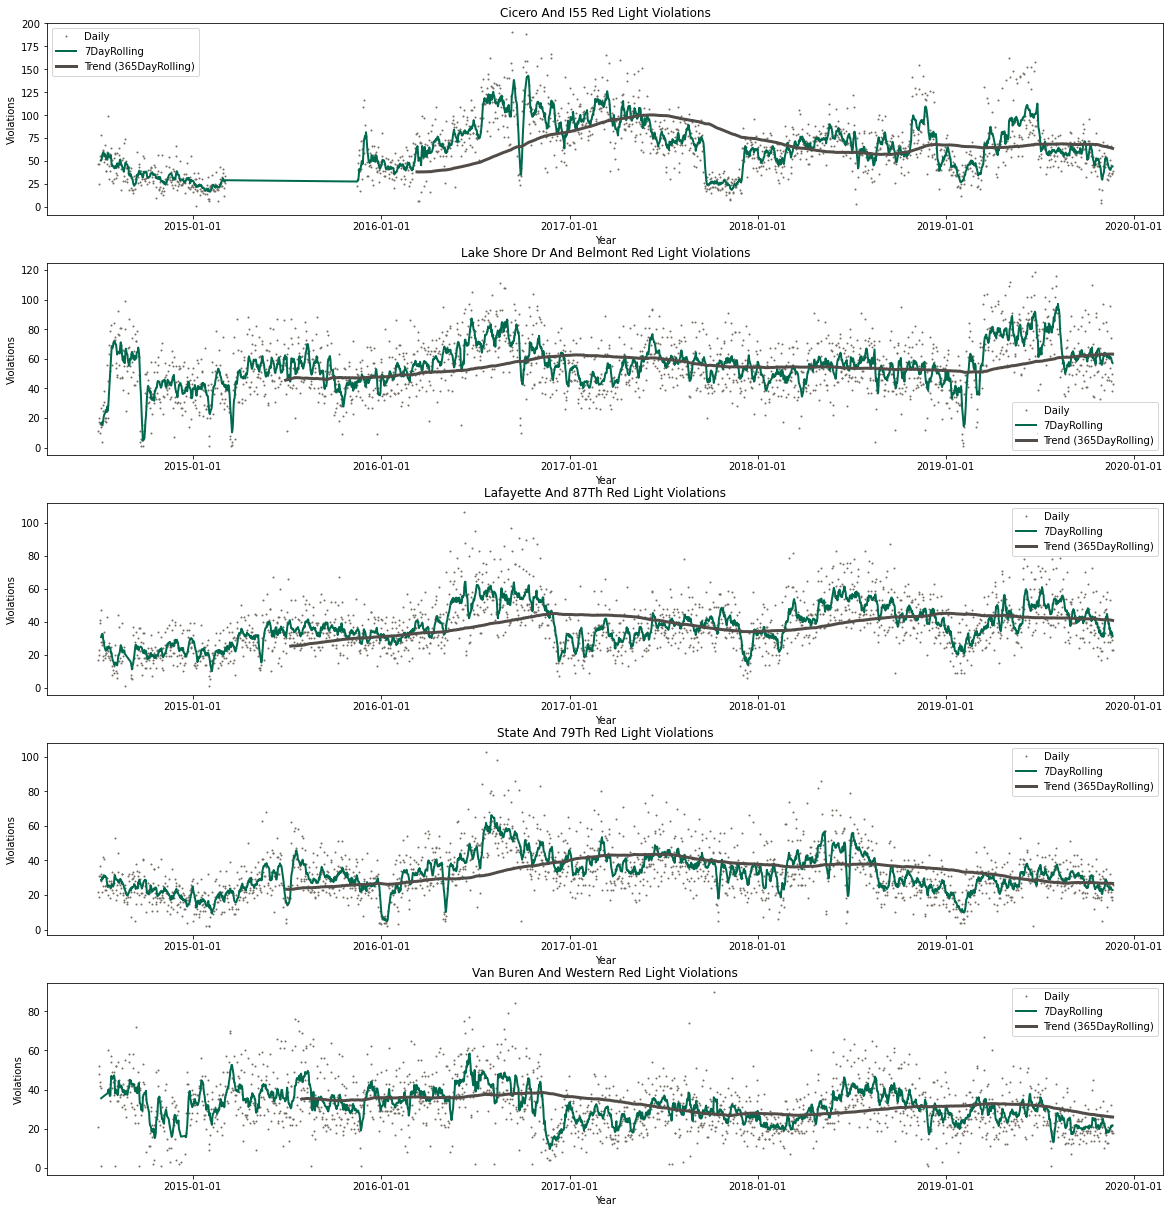

In [26]:
fig, axs = plt.subplots(5, figsize=(20,20))
for i, intersection in enumerate(top5Intersections):
    axs[i].plot(dfViolationsWithWeather['VIOLATIONS'][intersection], marker='.', markersize=2, color=ouColors['Putnam'],linestyle='None', label='Daily')
    axs[i].plot(dfViolationsWithWeather['7Day'][intersection], color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')
    axs[i].plot(dfViolationsWithWeather['365Day'][intersection], color=ouColors['Gateway'], linewidth=3, label='Trend (365DayRolling)')


    axs[i].xaxis.set_major_locator(mdates.YearLocator())
    axs[i].legend()
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Violations')
    axs[i].set_title(f'{top5Intersections[i].title()} Red Light Violations')
    
plt.subplots_adjust(bottom=0.08, hspace=0.25)
plt.show()

### <a id="2.3">2.3 Kmeans Clustering</a>  
[top](#top)

In [27]:
cols = ['year','month','dow','snow_ice_pellets','fog','snow_depth','wdsp','temp','VIOLATIONS']
X = preprocessing.normalize(dfViolationsWithWeather[cols], norm='l1', axis=0)
X_Grouped = preprocessing.normalize(dfGroupedViolations[cols], norm='l1', axis=0)

In [28]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,11) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(init='random',n_clusters=k, random_state=0).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(distance.cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

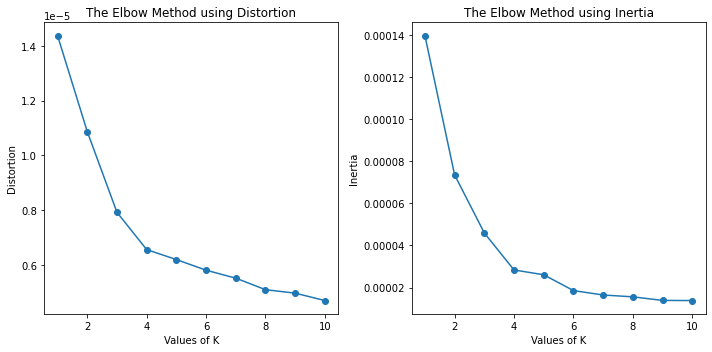

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(K, distortions, 'o-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 

plt.subplot(122)
plt.plot(K, inertias, 'o-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.tight_layout()



In [30]:
cluster = KMeans(n_clusters=4, random_state=0).fit(X)

dfViolationsWithWeather['clusters']=cluster.labels_

cluster1 = dfViolationsWithWeather[dfViolationsWithWeather['clusters']==1]['VIOLATIONS'].reset_index()
cluster1 = cluster1.groupby('VIOLATION DATE')['VIOLATIONS'].sum()
cluster2 = dfViolationsWithWeather[dfViolationsWithWeather['clusters']==2]['VIOLATIONS'].reset_index()
cluster2 = cluster2.groupby('VIOLATION DATE')['VIOLATIONS'].sum() #Winter Cluster
cluster3 = dfViolationsWithWeather[dfViolationsWithWeather['clusters']==3]['VIOLATIONS'].reset_index()
cluster3 = cluster3.groupby('VIOLATION DATE')['VIOLATIONS'].sum()
cluster0 = dfViolationsWithWeather[dfViolationsWithWeather['clusters']==0]['VIOLATIONS'].reset_index()
cluster0 = cluster0.groupby('VIOLATION DATE')['VIOLATIONS'].sum() #Seasonal

In [31]:
groupedCluster = KMeans(n_clusters=4, random_state=0).fit(X_Grouped)
dfGroupedViolations['clusters']=groupedCluster.labels_

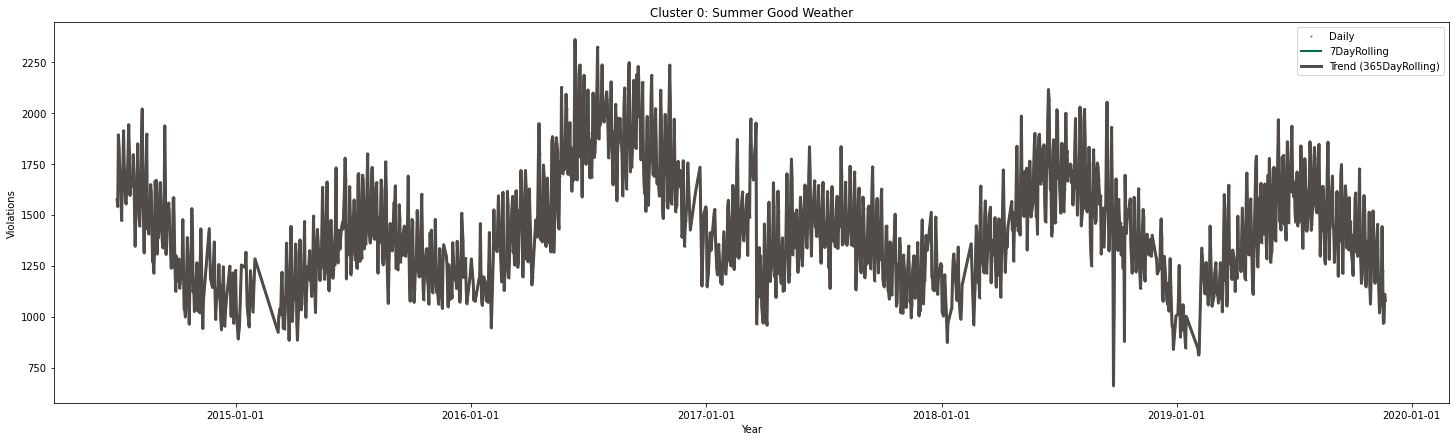

In [32]:
fig, axs = plt.subplots(figsize=(25,7))

axs.plot(cluster0, marker='.', markersize=2, color=ouColors['Putnam'],linestyle='None', label='Daily')
axs.plot(cluster0, color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')
axs.plot(cluster0, color=ouColors['Gateway'], linewidth=3, label='Trend (365DayRolling)')


axs.xaxis.set_major_locator(mdates.YearLocator())
axs.legend()
axs.set_xlabel('Year')
axs.set_ylabel('Violations')
axs.set_title(f'Cluster 0: Summer Good Weather')

plt.show()

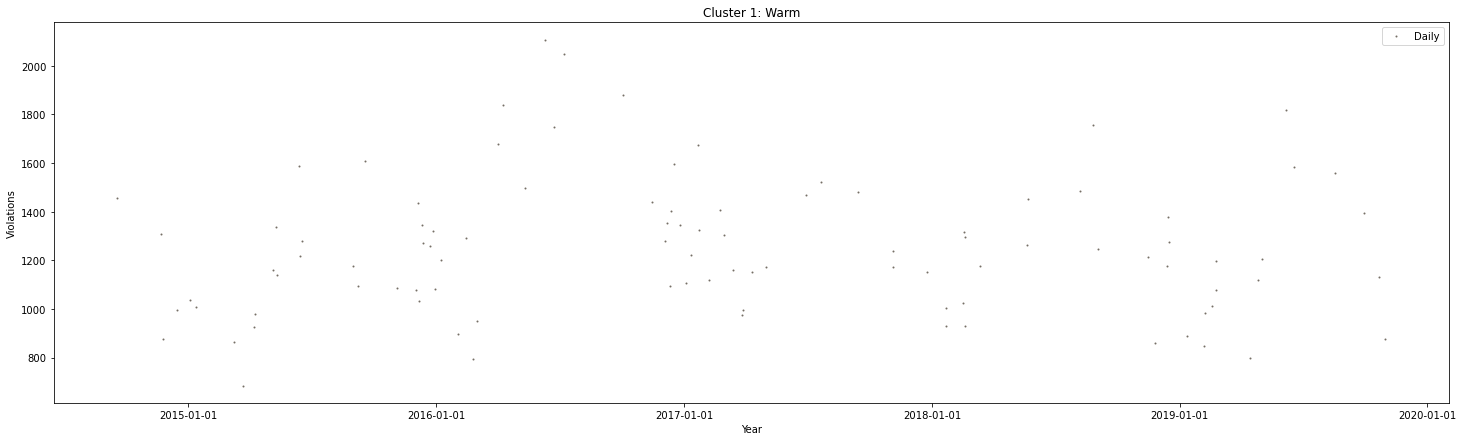

In [33]:
fig, axs = plt.subplots(figsize=(25,7))

axs.plot(cluster1, marker='.', markersize=2, color=ouColors['Putnam'],linestyle='None', label='Daily')
#axs.plot(cluster1, color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')
#axs.plot(cluster1, color=ouColors['Gateway'], linewidth=3, label='Trend (365DayRolling)')


axs.xaxis.set_major_locator(mdates.YearLocator())
axs.legend()
axs.set_xlabel('Year')
axs.set_ylabel('Violations')
axs.set_title(f'Cluster 1: Warm')

plt.show()

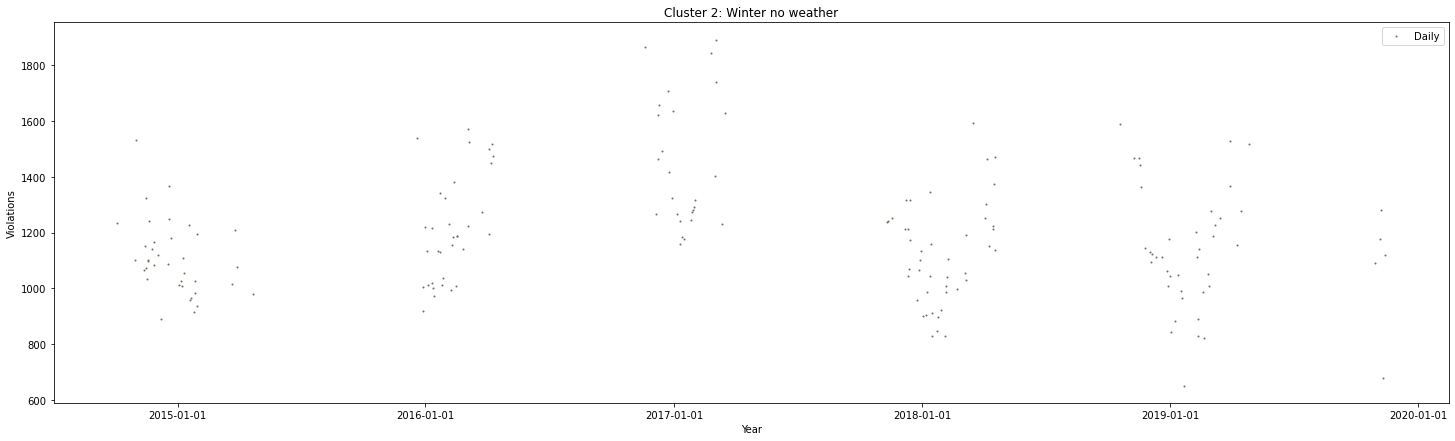

In [34]:
fig, axs = plt.subplots(figsize=(25,7))

axs.plot(cluster2, marker='.', markersize=2, color=ouColors['Putnam'],linestyle='None', label='Daily')
#axs.plot(cluster2, color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')
#axs.plot(cluster2, color=ouColors['Gateway'], linewidth=3, label='Trend (365DayRolling)')


axs.xaxis.set_major_locator(mdates.YearLocator())
axs.legend()
axs.set_xlabel('Year')
axs.set_ylabel('Violations')
axs.set_title(f'Cluster 2: Winter no weather')

plt.show()

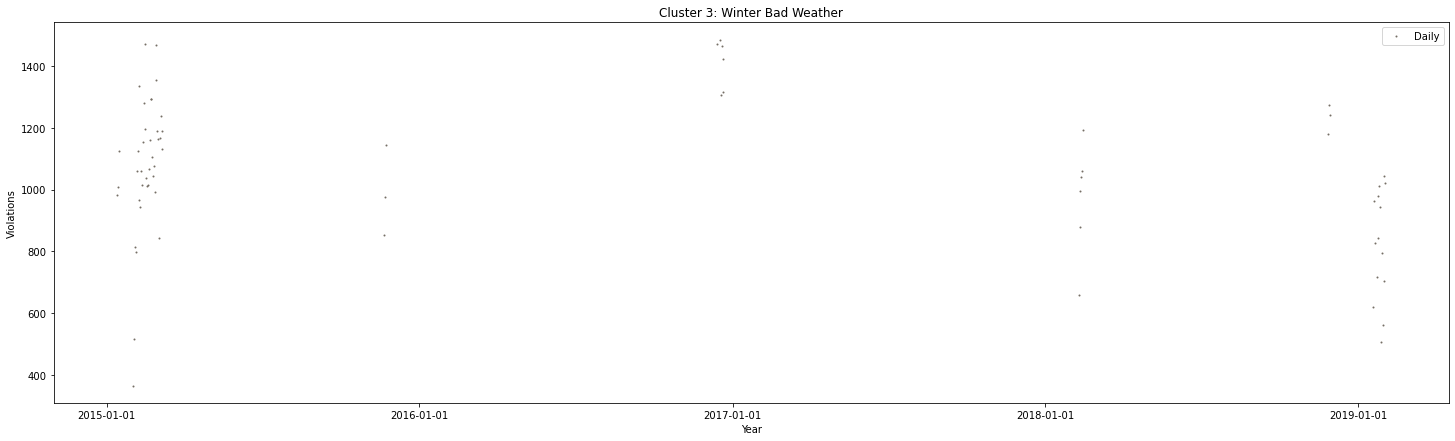

In [35]:
fig, axs = plt.subplots(figsize=(25,7))

axs.plot(cluster3, marker='.', markersize=2, color=ouColors['Putnam'],linestyle='None', label='Daily')
#axs.plot(cluster3, color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')
#axs.plot(cluster3, color=ouColors['Gateway'], linewidth=3, label='Trend (365DayRolling)')


axs.xaxis.set_major_locator(mdates.YearLocator())
axs.legend()
axs.set_xlabel('Year')
axs.set_ylabel('Violations')
axs.set_title(f'Cluster 3: Winter Bad Weather')

plt.show()

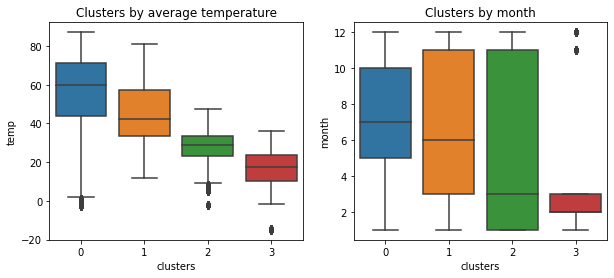

In [36]:
# boxplotCols = ['month','dow']
#'fog','rain_drizzle','snow_ice_pellets','hail','thunder']
fig, ax = plt.subplots(2, figsize=(10,4))

plt.subplot(121)
sns.boxplot(x='clusters', y='temp', data = dfViolationsWithWeather)
plt.title('Clusters by average temperature')

plt.subplot(122)
sns.boxplot(x='clusters', y='month', data = dfViolationsWithWeather)
plt.title('Clusters by month')
#plt.tight_layout()
plt.show()


## <a id="3">3 Prediction</a>  
[top](#top)

In [37]:
#get the mean squared error for the simple average to compare each model too. Models should be better than the simplest form of prediction.
meanViolations = dfGroupedViolations['VIOLATIONS'].mean()
baselineError = mean_squared_error(dfGroupedViolations['VIOLATIONS'].values, np.full((1970,),meanViolations))
baselineError

82542.83736787859

In [38]:
#Create functions for determining the accuracy of the models
def model_performance(X_train,y_train,X_test,y_test,model):
    trainingScores = pd.DataFrame(y_train.copy(), columns=['Actual'])
    trainingScores['Prediction'] = model.predict(X_train)
    trainingScores['Residual'] = trainingScores['Actual']-trainingScores['Prediction']

    validationScores = pd.DataFrame(y_test.copy(), columns=['Actual'])
    validationScores['Prediction'] = model.predict(X_test)
    validationScores['Residual'] = validationScores['Actual']-validationScores['Prediction']

    data = {'SSE': [sum(trainingScores['Residual']**2),sum(validationScores['Residual']**2)],
            'MSE': [mean_squared_error(trainingScores['Actual'], trainingScores['Prediction']), mean_squared_error(validationScores['Actual'], validationScores['Prediction'])],
            'RMSE': [mean_squared_error(trainingScores['Actual'], trainingScores['Prediction'])**.5, mean_squared_error(validationScores['Actual'], validationScores['Prediction'])**.5],
            'MAD': [mean(absolute(trainingScores['Residual'])),mean(absolute(validationScores['Residual']))],
            'R2': [r2_score(trainingScores['Actual'], trainingScores['Prediction']), r2_score(validationScores['Actual'], validationScores['Prediction'])]}

    df_summary = pd.DataFrame.from_dict(data, orient='index', columns=['Training', 'Validation'])
    df_summary['%Difference'] = (df_summary['Training']-df_summary['Validation'])/df_summary['Training']*100
    return df_summary

def steyx(y,x):
    """Determines the standard error of the predicted y value for each actual y or
    the measure of the amount of error in the prediction of y for an individual x"""
    y_mean = mean(y)
    x_mean = mean(x)

    sumYSquare = sum((y-mean(y))**2)
    sumXSquare = sum((x-mean(x))**2)

    sumDiffSquare = sum((y-mean(y))*(x-mean(x)))**2

    dof = len(y)-2

    return ((1/dof)*(sumYSquare-(sumDiffSquare/sumXSquare)))**.5

### <a id="3.1">3.1 Linear Regression</a>
[top](#top)

In [65]:
#60/40 train test split
#determine number of records for a 60/40 train/test split
split = int(len(dfGroupedViolations)*.6)
#create dummy variables for any categorical variables left in dataset
xCols = ['year','month','dow','temp','wdsp','max_temp','min_temp','prcp','snow_depth','fog','rain_drizzle','snow_ice_pellets','hail','thunder','clusters']
X = dfGroupedViolations[xCols]
y = dfGroupedViolations['VIOLATIONS']

X_train = X[0:split]
y_train = y[0:split].ravel()
X_test = X[split:]
y_test = y[split:].ravel()

regr = LinearRegression()
regr.fit(X_train,y_train)
pred = regr.predict(X_test)

#Display the coefficients for the linear regression model
predictor = ['Intercept']+ xCols
lrCoefficient = pd.DataFrame(zip(predictor,regr.coef_.reshape(15)),columns=['Predictor','Estimate'])
lrCoefficient

,Predictor,Estimate
0,Intercept,76.840343
1,year,12.599931
2,month,50.556550
3,dow,1.382317
4,temp,-5.310090
5,wdsp,3.475704
6,max_temp,1.836763
7,min_temp,-20.845373
8,prcp,-8.747322
9,snow_depth,-79.257724


In [97]:
lr_forecast = regr.predict(X)
lr_residual = y - lr_forecast

full_lr_performance = model_performance(X_train, y_train, X_test, y_test, regr)
full_lr_performance.round(2)

,Training,Validation,%Difference
SSE,54246567.40,72352951.66,-33.38
MSE,45893.88,91818.47,-100.07
RMSE,214.23,303.02,-41.45
MAD,175.48,261.44,-48.98
R2,0.47,-0.24,151.65


In [67]:
#step forward feature selection
sfsl = sfs(regr,
          k_features=7,
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)

sfsl = sfsl.fit(X_train, y_train)
sf_Cols = list(sfsl.k_feature_names_)
sf_Cols

['year', 'month', 'dow', 'max_temp', 'fog', 'rain_drizzle', 'thunder']

In [68]:
#Linear Regression with reduced columns
X_reduced = dfGroupedViolations[sf_Cols]
y_reduced = dfGroupedViolations['VIOLATIONS']

X_train_reduced = X_reduced[0:1182]
y_train_reduced = y_reduced[0:1182].ravel()
X_test_reduced = X_reduced[1182:]
y_test_reduced = y_reduced[1182:].ravel()

regr_reduced = LinearRegression()
regr_reduced.fit(X_train_reduced,y_train_reduced)
pred_reduced = regr_reduced.predict(X_test_reduced)

#Display the coefficients for the linear regression model
predictor_reduced = ['Intercept']+ sf_Cols
lr_reduced_coefficient = pd.DataFrame(zip(predictor_reduced,regr_reduced.coef_.reshape(7)),columns=['Predictor','Estimate'])
lr_reduced_coefficient

,Predictor,Estimate
0,Intercept,77.322793
1,year,13.914366
2,month,51.137860
3,dow,6.478831
4,max_temp,-109.355589
5,fog,-90.087626
6,rain_drizzle,63.753141


In [106]:
lr_forecast_reduced = regr_reduced.predict(X_reduced)
lr_residual_reduced = y_reduced - lr_forecast

reduced_lr_performance = model_performance(X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced, regr_reduced)
reduced_lr_performance.round(2)

,Training,Validation,%Difference
SSE,55011492.28,72529442.15,-31.84
MSE,46541.03,92042.44,-97.77
RMSE,215.73,303.38,-40.63
MAD,176.29,261.49,-48.33
R2,0.46,-0.25,153.13


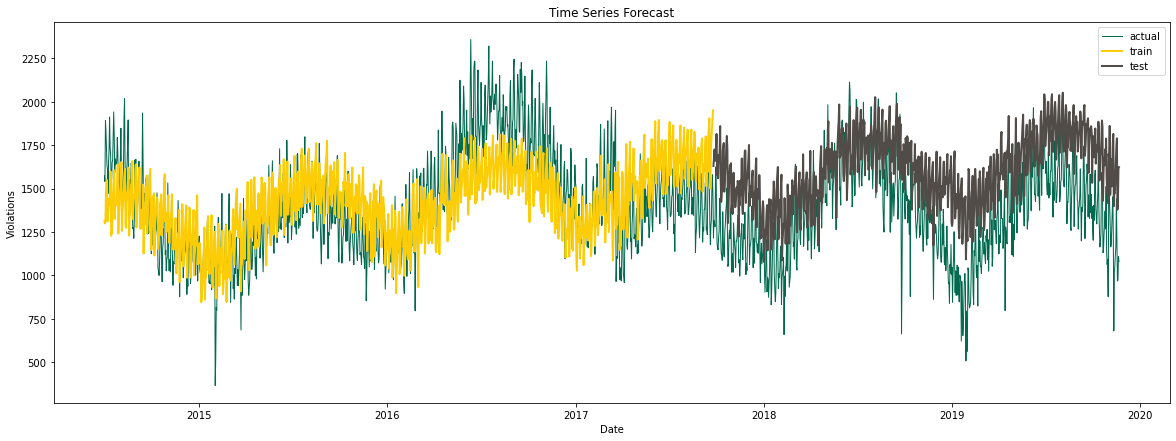

In [71]:
#Visualization of linear regression full model
train_vals = pd.DataFrame(regr_reduced.predict(X_train_reduced), index=X_train_reduced.index, columns=['pred'])
test_vals = pd.DataFrame(regr_reduced.predict(X_test_reduced), index=X_test_reduced.index, columns=['pred'])
# visualization
plt.figure(figsize=(20,7))
plt.plot(dfGroupedViolations['VIOLATIONS'], color=ouColors['Cutler Green'], linewidth=1, label='actual')
plt.plot(train_vals,color=ouColors['Wheat'], linewidth=2, label = "train")
plt.plot(test_vals,color=ouColors['Gateway'], linewidth=2, label = "test")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Violations")
plt.legend()
plt.show()

### <a id="3.2">3.2 ARIMA</a>
[top](#top)

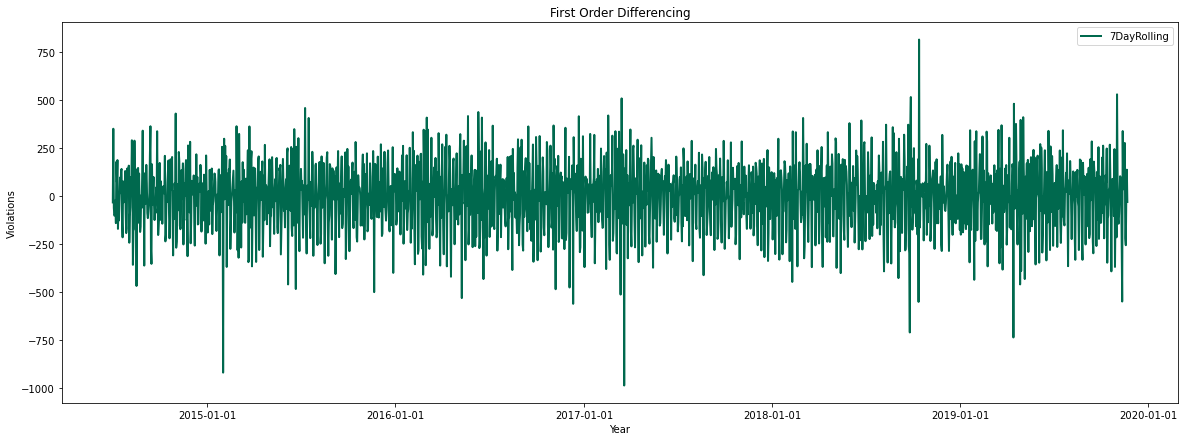

In [50]:
firstOrderDiff = dfGroupedViolations['VIOLATIONS'].diff()
firstOrderDiff.dropna(inplace=True)

fig, axs = plt.subplots(figsize=(20,7))

axs.plot(firstOrderDiff, color=ouColors['Cutler Green'], linewidth=2, label='7DayRolling')

axs.xaxis.set_major_locator(mdates.YearLocator())
axs.legend()
axs.set_xlabel('Year')
axs.set_ylabel('Violations')
axs.set_title(f'First Order Differencing')

plt.show()

The timeseries is now stationary because the P value is below the cutoff of .05 and the ADF statistic is less than the 1% critical value.

In [51]:
result = adfuller(firstOrderDiff)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: ')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -11.801705045573817
p-value: 9.297626143602058e-22
Critical Values: 
	1%: -3.433721763505903
	5%: -2.8630294391572706
	10%: -2.567562917840866


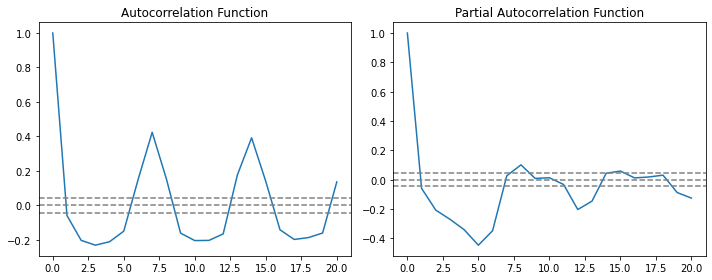

In [52]:
lag_acf = acf(firstOrderDiff, nlags=20)
lag_pacf = pacf(firstOrderDiff, nlags=20, method='ols')

# ACF
plt.figure(figsize=(10,4))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(firstOrderDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(firstOrderDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(firstOrderDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(firstOrderDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

error:  13800.300370337689


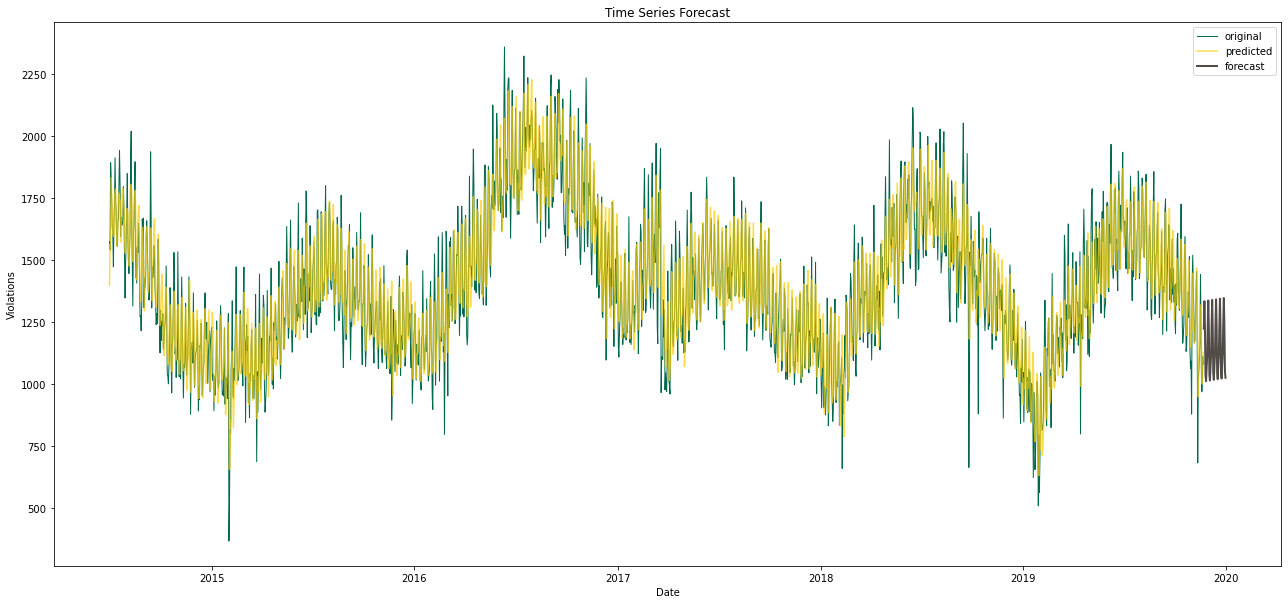

In [53]:
# predict all path
start_index = '2019-11-22'
end_index = '2019-12-31'
# fit model
model = ARIMA(dfGroupedViolations['VIOLATIONS'], order=(5,0,6))
model_fit = model.fit(disp=0)
forecast = model_fit.predict()
futureforecast = model_fit.predict(start=start_index, end=end_index)
error = mean_squared_error(dfGroupedViolations['VIOLATIONS'], forecast)
print("error: " ,error)

# visualization
plt.figure(figsize=(22,10))
plt.plot(dfGroupedViolations['VIOLATIONS'],color=ouColors['Cutler Green'], linewidth=1, label = "original")
plt.plot(forecast,alpha=.7,color=ouColors['Wheat'], label = "predicted")
plt.plot(futureforecast, color=ouColors['Gateway'],linewidth=2,label = "forecast")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Violations")
plt.legend()

plt.show()

In [80]:
error = mean_squared_error(dfGroupedViolations['VIOLATIONS'], forecast)
arima_residual = dfGroupedViolations['VIOLATIONS'] - forecast


data = {'SSE': [sum(arima_residual**2)],
        'MSE': [mean_squared_error(dfGroupedViolations['VIOLATIONS'], forecast)],
        'RMSE': [mean_squared_error(dfGroupedViolations['VIOLATIONS'], forecast)**.5],
        'MAD': [mean(absolute(arima_residual))],
        'R2': [r2_score(dfGroupedViolations['VIOLATIONS'], forecast)]}

df_summary = pd.DataFrame.from_dict(data, orient='index', columns=['ARIMA'])
df_summary.round(2)

,ARIMA
SSE,27186591.73
MSE,13800.30
RMSE,117.47
MAD,89.07
R2,0.83


### <a id="3.3">3.3 Facebook Prophet</a>  
[top](#top)

In [55]:
dfGroupedViolations.head()
dailyViolations = dfGroupedViolations['VIOLATIONS'].reset_index()
dailyViolations.columns = ['ds', 'y']
dailyViolations.head()

,ds,y
0,2014-07-01,1572
1,2014-07-02,1540
2,2014-07-03,1891
3,2014-07-04,1830
4,2014-07-05,1729


In [56]:
m=Prophet(yearly_seasonality=True, weekly_seasonality=True) 
m.add_seasonality(name='weekly', period=7, fourier_order=3)

m.fit(dailyViolations)

future = m.make_future_dataframe(freq='D', periods=39)  #Predict violations through the end of 2020

future.tail()

,ds
2004,2019-12-26
2005,2019-12-27
2006,2019-12-28
2007,2019-12-29
2008,2019-12-30


Text(0.5, 1.0, 'Facebook Prophet Forecast')

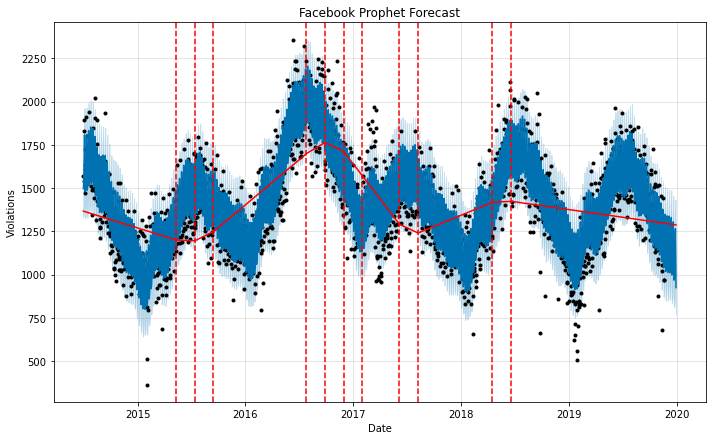

In [57]:
fb_forecast = m.predict(future)
fig = m.plot(fb_forecast, xlabel='Date', ylabel='Violations')
ax = fig.gca()
a = add_changepoints_to_plot(ax,m, fb_forecast)
ax.set_title("Facebook Prophet Forecast")


In [58]:
fb_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(39)


,ds,yhat,yhat_lower,yhat_upper
1970,2019-11-22,1248.605722,1082.118204,1401.887804
1971,2019-11-23,1349.539554,1181.400649,1507.550484
1972,2019-11-24,1210.372744,1052.411008,1362.919367
1973,2019-11-25,1018.474027,852.100352,1170.195446
1974,2019-11-26,1025.598996,869.225735,1167.453693
1975,2019-11-27,1050.161636,896.821210,1216.159457
1976,2019-11-28,1106.805762,945.451420,1268.314218
1977,2019-11-29,1237.061131,1074.095346,1397.393642
1978,2019-11-30,1340.060468,1186.443431,1498.228519
1979,2019-12-01,1202.769610,1039.075083,1364.436843


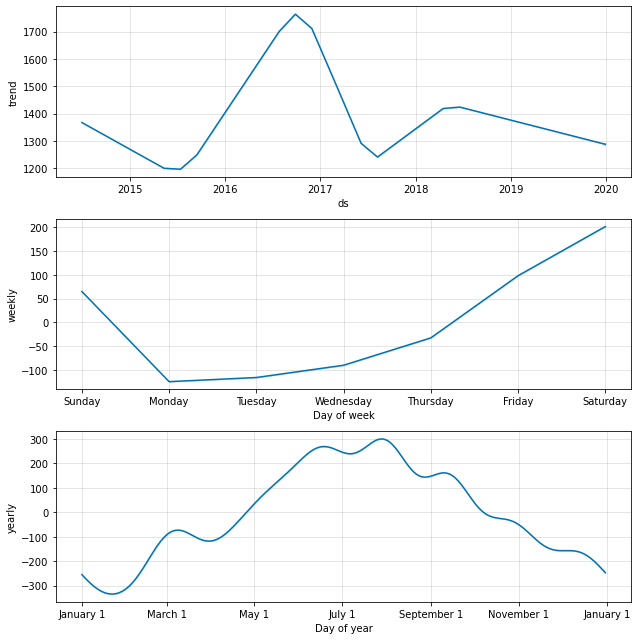

In [60]:
fig2 = m.plot_components(fb_forecast)

In [61]:
actuals = dailyViolations['y']
fb_est = fb_forecast.loc[:1969]['yhat']
fb_residual = actuals - fb_est


data = {'SSE': [sum(fb_residual**2)],
        'MSE': [mean_squared_error(actuals, fb_est)],
        'RMSE': [mean_squared_error(actuals, fb_est)**.5],
        'MAD': [mean(absolute(fb_residual))],
        'R2': [r2_score(actuals, fb_est)]}

df_summary = pd.DataFrame.from_dict(data, orient='index', columns=['FBProphet'])
df_summary.round(2)

,FBProphet
SSE,30118801.50
MSE,15288.73
RMSE,123.65
MAD,94.46
R2,0.81


### <a id="4">#4 Conclusions</a>
[top](#top)



In [94]:
T = t.ppf(1-(.05/2),(len(actuals)-1))


lr_preds = list(regr.predict(X_train))+list(regr.predict(X_test))
lr_residual = actuals-lr_preds

True

Text(0.5, 1.0, 'Estimate vs Estimate Plot: FB Prophet')

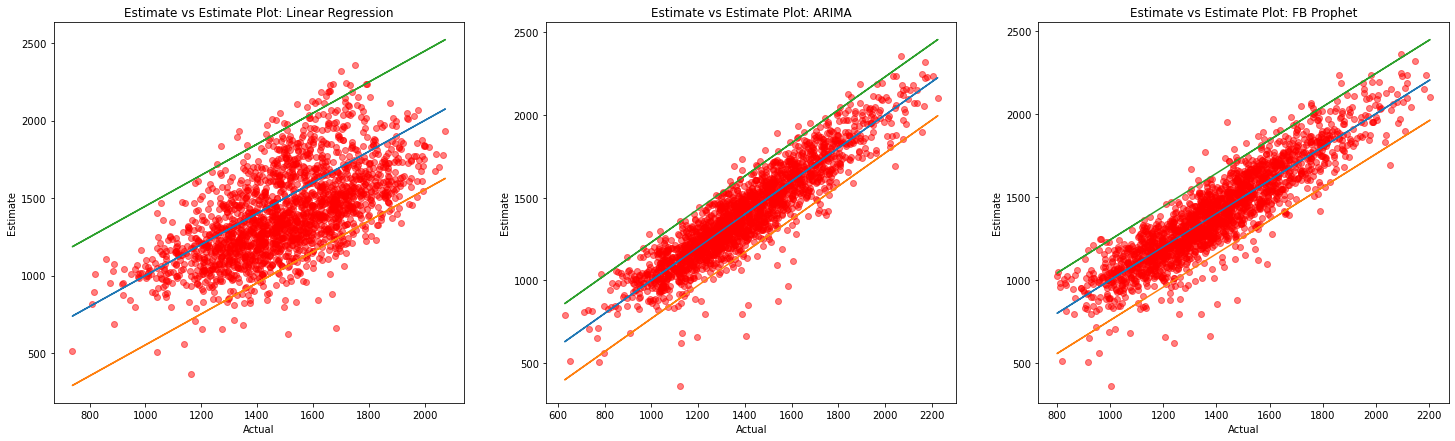

In [95]:
#1 to 1 plots for each model
#Linear Regression

plt.figure(3, figsize=(25,7))

plt.subplot(131)
a = plt.plot(lr_preds,actuals,'ro',alpha=0.5, label='actuals')
a1 = plt.plot(lr_preds,lr_preds,label='predictions')
a2 = plt.plot(lr_preds,lr_preds-T*steyx(actuals,lr_preds),label='-95% PI')
a3 = plt.plot(lr_preds,lr_preds+T*steyx(actuals,lr_preds),label='+95% PI')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: Linear Regression')

plt.subplot(132)
a = plt.plot(forecast,actuals,'ro',alpha=0.5, label='actuals')
a1 = plt.plot(forecast,forecast,label='predictions')
a2 = plt.plot(forecast,forecast-T*steyx(actuals,forecast.values),label='-95% PI')
a3 = plt.plot(forecast,forecast+T*steyx(actuals,forecast.values),label='+95% PI')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: ARIMA')

plt.subplot(133)
a = plt.plot(fb_est,actuals,'ro',alpha=0.5, label='actuals')
a1 = plt.plot(fb_est,fb_est,label='predictions')
a2 = plt.plot(fb_est,fb_est-T*steyx(actuals,fb_est.values),label='-95% PI')
a3 = plt.plot(fb_est,fb_est+T*steyx(actuals,fb_est.values),label='+95% PI')
plt.xlabel('Actual')
plt.ylabel('Estimate')
plt.title('Estimate vs Estimate Plot: FB Prophet')

In [109]:
data = {'SSE': [sum((lr_residual)**2),sum(arima_residual**2),sum(fb_residual**2)],
       'MSE': [mean_squared_error(actuals, lr_preds),  mean_squared_error(actuals, forecast), mean_squared_error(actuals, fb_est)],
       'RMSE': [mean_squared_error(actuals, lr_preds)**.5, mean_squared_error(actuals, forecast)**.5,mean_squared_error(actuals, fb_est)**.5],
       'MAD': [mean(absolute(lr_residual)), mean(absolute(arima_residual)),mean(absolute(fb_residual))],
       'R2': [r2_score(actuals, lr_preds), r2_score(actuals, forecast),r2_score(actuals, fb_est)]}

dfSummary = pd.DataFrame.from_dict(data, orient='index', columns=['Logistic Regression', 'ARIMA', 'FB Prophet'])
dfSummary.round(2)

,Logistic Regression,Logistic Regression Reduced,ARIMA,FB Prophet
SSE,1.265995e+08,1.265995e+08,27186591.73,30118801.50
MSE,6.426372e+04,6.474159e+04,13800.30,15288.73
RMSE,2.535000e+02,2.544400e+02,117.47,123.65
MAD,2.098600e+02,2.098600e+02,89.07,94.46
R2,2.200000e-01,2.200000e-01,0.83,0.81
